# Accelerated Numpy

The notebook demonstrates the performance in switching between various underlying
engine, e.g. JAX / Tensorflow, to run NumPy operations in CPU and GPU.

In Google Colab, please follow the following steps to change to GPU runtime type

1. Click "Runtime" -> "Change runtime type" at the top bar
2. Choose "GPU" in "Hardware accelerator" and "T4" in "GPU type"
3. Press "Save" button to switch runtime type

(Currently the functionality is only available in the feature branch `feature/tnp`)

In [1]:
!pip install git+https://github.com/gavincyi/arch.git@feature/tnp

  Cloning https://github.com/gavincyi/arch.git (to revision feature/tnp) to /tmp/pip-req-build-x_5egqd7
  Running command git clone --filter=blob:none --quiet https://github.com/gavincyi/arch.git /tmp/pip-req-build-x_5egqd7
  Running command git checkout -b feature/tnp --track origin/feature/tnp
  Switched to a new branch 'feature/tnp'
  Branch 'feature/tnp' set up to track remote branch 'feature/tnp' from 'origin'.
  Resolved https://github.com/gavincyi/arch.git to commit d351c541fe5065f0fee1f32c79ba66b28838d974
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for arch: filename=arch-0.1.dev1038+gd351c54-cp310-cp310-linux_x86_64.whl size=1802322 sha256=4d31c2cea2fde6e59546f8f04ee4327b1fbe34302a6cbf22d446cf3950b7d0e5
  Stored in directory: /tmp/pip-ephem-wheel-cache-0uirgqcj/wheels/e0/96/b7/674f6b3592bc98941ccfa3c74700acca078de257ddd554cdbe
Successfully built arch
  Attempting uninstal

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Tuple
from time import time
import warnings

import pandas as pd

from arch.experimental.engine import use_backend
from arch.covariance.kernel import NeweyWest
from arch.typing import ArrayLike
from arch.unitroot import ADF

warnings.filterwarnings("ignore", category=UserWarning)

# Engines

If the CUDA library is installed with physical GPU, the below cell will return the
following output.

```
Supported engines: numpy, tensorflow, jax, cupy
```

In [3]:
ENGINES = ["numpy", "tensorflow", "jax"]

try:
    import tensorflow.test
    if len(tensorflow.config.list_physical_devices("GPU")):
        ENGINES.append("cupy")
except ImportError:
    raise ImportError("Tensorflow should be installed")

print(f"Supported engines: {', '.join(ENGINES)}")

Supported engines: numpy, tensorflow, jax


# Covariance

The following benchmarks measure the average runtime of covariance computation.

We will measure the runtime performance on 1-d and 2-d arrays.


In [5]:
def cov_get_data(size: Tuple[int, ...], burn: int = 500, use_pandas: bool = False) -> ArrayLike:
    import numpy as np
    rs = np.random.RandomState([3894830, 432841, 323297, 8927821])
    e = rs.standard_normal(size)
    ndim = len(size)
    if ndim == 1:
        phi = rs.uniform(0, 0.9, 1)
        for i in range(1, size[0]):
            e[i] += e[i - 1] * phi
    else:
        phi = np.diag(rs.uniform(0, 0.9, size[1]))
        for i in range(1, size[0]):
            e[i] += e[i - 1] @ phi
    e = e[burn:]
    if use_pandas:
        if ndim == 1:
            return pd.Series(e, name="x")
        else:
            return pd.DataFrame(e, columns=[f"x{i}" for i in range(e.shape[1])])
    return e

In [6]:
def cov_timeit(
    library: str,
    size: Tuple[int, ...] = (5000, ),
    estimator: object = NeweyWest,
    use_pandas: bool = False
):
    import numpy as np
    data = cov_get_data(size, use_pandas=use_pandas)

    def _func():
        cov = estimator(data).cov.long_run
        if library == "cupy":
            cov = cov.get()
        if not use_pandas:
            # Force to convert back to numpy array
            cov = np.asarray(cov)
        return cov

    with use_backend(library):
        # Warm start (e.g. JAX to compile the function first) and
        # estimate the runtime to determine the total number of runs
        start = time()
        cov = estimator(data).cov
        end = time()
        elapsed = end - start

        # Generally the total runtime should not be more than 10s
        if elapsed < 0.01:
            n_run = 1000
        elif elapsed < 0.1:
            n_run = 100
        elif elapsed < 1.0:
            n_run = 10
        else:
            n_run = 1

        # Get total runtime
        runtimes = [0.0] * n_run
        for index in range(n_run):
            start = time()
            ret = _func()
            end = time()
            runtimes[index] = end - start

    return 1000 * np.percentile(runtimes, 90), n_run, ret


First, we measure the runtimes on covariance computation on 1-d array of size
from 1000 to 7500.

For 1-d array, even with GPU activated, the NumPy still produces the best performance.

Text(0, 0.5, 'Runtime (ms)')

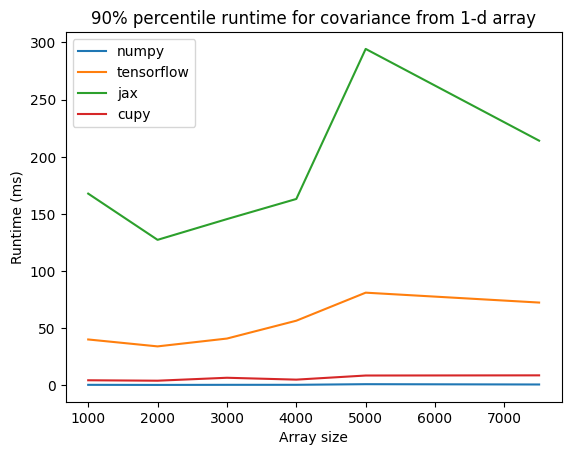

In [7]:
runtimes_1d = {}

for library in ENGINES:
    runtimes_1d[library] = {}
    for dim in [1000, 2000, 3000, 4000, 5000, 7500]:
        runtime = cov_timeit(library=library, size=(dim,))
        runtimes_1d[library][dim] = runtime[0]

ax = pd.DataFrame(runtimes_1d).plot(title="90% percentile runtime for covariance from 1-d array")
ax.set_xlabel("Array size")
ax.set_ylabel("Runtime (ms)")

For 2-d array, we measure the runtimes of covariance computation on matrix
with size (5000, N), where N ranges from 100 to 1000.

With GPU availability, the engines running on GPU runtime perform much better than
NumPy compatible only on CPU runtime.

Text(0, 0.5, 'Runtime (ms)')

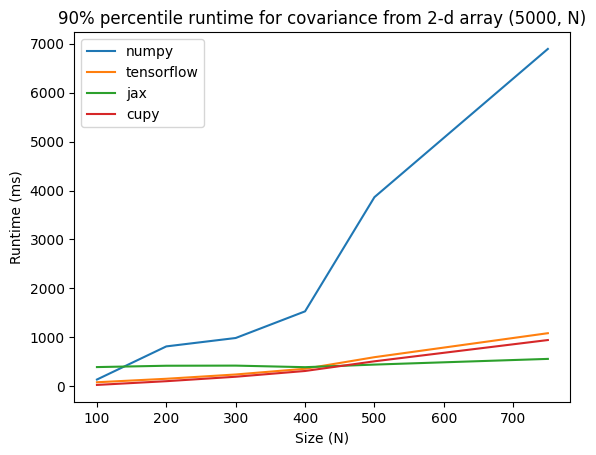

In [8]:
runtimes_2d = {}

for library in ENGINES:
    runtimes_2d[library] = {}
    for dim in [100, 200, 300, 400, 500, 750]:
        runtime = cov_timeit(library=library, size=(5000, dim))
        runtimes_2d[library][dim] = runtime[0]

ax = pd.DataFrame(runtimes_2d).plot(title="90% percentile runtime for covariance from 2-d array (5000, N)")
ax.set_xlabel("Size (N)")
ax.set_ylabel("Runtime (ms)")

# Unitroot

In [5]:
def unitroot_get_data(size: int):
    import numpy as np
    rnd = np.random.RandomState(12345)
    return np.cumsum(rnd.standard_normal(size))

In [6]:
def unitroot_timeit(
    library: str,
    size: int,
    estimator: object = ADF,
):
    import numpy as np
    data = unitroot_get_data(size)

    def _func():
        return estimator(data).summary()

    with use_backend(library):
        # Warm start (e.g. JAX to compile the function first) and
        # estimate the runtime to determine the total number of runs
        start = time()
        _func()
        end = time()
        elapsed = end - start

        # Generally the total runtime should not be more than 10s
        if elapsed < 0.001:
            n_run = 10000
        elif elapsed < 0.01:
            n_run = 1000
        elif elapsed < 0.1:
            n_run = 100
        elif elapsed < 1.0:
            n_run = 10
        else:
            n_run = 1

        # Get total runtime
        runtimes = [0.0] * n_run
        for index in range(n_run):
            start = time()
            ret = _func()
            end = time()
            runtimes[index] = end - start

    # Output: time in ms, number of runs and estimation result
    return 1000 * np.percentile(runtimes, 90), n_run, ret


Text(0, 0.5, 'Runtime (ms)')

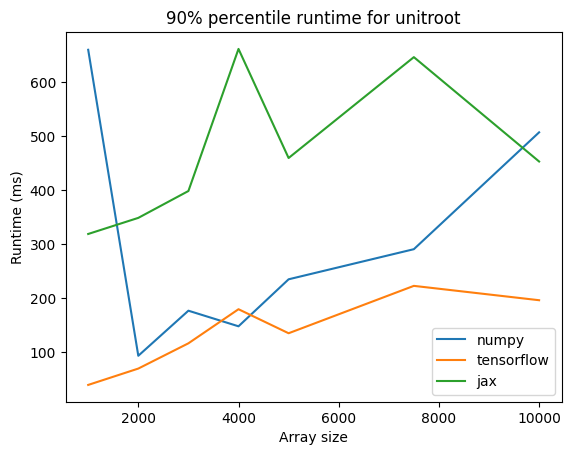

In [8]:
runtimes = {}

for library in ENGINES:
    if library == "cupy":
        continue

    runtimes[library] = {}
    for dim in [1000, 2000, 3000, 4000, 5000, 7500, 10000]:
        runtime = unitroot_timeit(library=library, size=dim)
        runtimes[library][dim] = runtime[0]

ax = pd.DataFrame(runtimes).plot(title="90% percentile runtime for unitroot")
ax.set_xlabel("Array size")
ax.set_ylabel("Runtime (ms)")